In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.model_selection import KFold

import xml.etree.ElementTree as Xet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from IPython.display import Image, HTML
from datetime import datetime
from langdetect import detect
import re

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

Version:      2.4.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7

In [5]:
VAL_FRACTION = 0.25

In [6]:
MIN_COMMENT_LEN = 25

In [7]:
TOP_N = 5

In [8]:
MODEL_NAME = "https://tfhub.dev/google/nnlm-en-dim50/2"

## GET DATA

In [9]:
def get_hot_data():
    hot = requests.get("https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame").content.decode()
  
    # Parsing the XML file
    xmlparse = Xet.fromstring(hot)

    hot_array = []
    for item in xmlparse:
        dict_element = {
            "id": item.get("id"),
            "rank": item.get("rank")
        }
        for option in item:
            dict_element[option.tag] = option.get("value")
        hot_array.append(dict_element)
    return hot_array

In [10]:
def get_comments(id_array, verbose=1):
    max_comments_per_page = 1
    array_ids = [h['id'] for h in id_array]
    ids = ','.join(array_ids)
    page_size = 100
    page_number = 0
    comments_array = []

    while max_comments_per_page > 0 and len(array_ids) > 0:
        page_number += 1
        if verbose>0 and page_number%verbose==0:
            print(f"page number = {page_number}", end=" ")
        comments = requests.get(f"https://www.boardgamegeek.com/xmlapi2/thing?id={ids}&comments=1&pagesize={page_size}&page={page_number}").content.decode()

        # Parsing the XML file
        xmlparse = Xet.fromstring(comments)
        comments_per_item = []
        for item in xmlparse:        
            for option in item:
                if option.tag == 'comments':
                    comments_per_page = 0
                    for comment in option:
                        comments_per_page += 1
                        dict_element = {
                            "id": item.get("id"),
                            "username": comment.get("username"),
                            "rating": comment.get("rating"),
                            "value": comment.get("value")
                        }
                        comments_array.append(dict_element)
                    if comments_per_page==0:
                        array_ids.remove(item.get("id"))
                        ids = ','.join(array_ids)
                    comments_per_item.append(comments_per_page)
        max_comments_per_page = max(comments_per_item)
        if verbose>0 and page_number%verbose==0:
            print(f"(max: {max(comments_per_item)}, len: {len(comments_per_item)})")
    comments_df = pd.DataFrame(comments_array)
    print(f"comments_df shape: {comments_df.shape}")
    return comments_df

In [11]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '223040',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/A7IOpPt-lHrMYsbRmxXWdQ__thumb/img/XoD3fXgApfY7-dfYyFeE6FVkbfY=/fit-in/200x150/filters:strip_icc()/pic6177962.jpg',
  'name': 'Fantasy Realms',
  'yearpublished': '2017'},
 {'id': '285192',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/oaD1ZQ3yGj6lacLdtqgdnQ__thumb/img/1mCz7HPEFMeqaqJHsDZwEUc9ftw=/fit-in/200x150/filters:strip_icc()/pic5558118.png',
  'name': 'Destinies',
  'yearpublished': '2021'}]

In [12]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

reading dataframe from csv file...


,id,username,rating,value
0,223040,4rch3r,8.5,"""301 ist maximale Punktzahl"""
1,223040,9zero21zero,8.0,Sleeved - Mayday 7077
2,223040,Abdul,6.0,Maths homework disguised as a game. It's fine ...
3,223040,absolutleo,8.0,My wife tries to veto a 10 - so 9 is a comprom...
4,223040,Adam78,9.0,This is great. One of the simplest rulesets go...
...,...,...,...,...
87330,167791,z_zadar,9.0,Some games are so much fun. Others can be a li...
87331,167791,_Czid_,8.0,Have played with Elysium and Prelude expansion...
87332,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
87333,167791,_mun_,10.0,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [13]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  

In [14]:
comments_df["value"] = comments_df["value"].astype(str)

In [15]:
# REMOVE URLs FROM COMMENTS

In [16]:
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]

In [17]:
# REMOVE SHORT COMMENTS
def remove_short_comments(df: pd.DataFrame, min_len=25, method='unrated'):
    if method not in ['unrated', 'rated', 'both']:
        raise AttributeError(f"method {method} not allowed")
    df_local = df.copy()    
    df_local['comment_len'] = [len(re.findall("[A-Za-z]", v)) for v in df_local['value'].values]
    if method == 'rated':
        df_local = df_local.query('(comment_len>@min_len and rating != "N/A") or rating == "N/A"')
    elif method == 'unrated':
        df_local = df_local.query('(comment_len>@min_len and rating == "N/A") or rating != "N/A"')
    else:
        df_local = df_local.query('comment_len>@min_len')
    print(f"removed {len(df)-len(df_local)} for 'remove_short_comments' - min len: {min_len} - method: {method}")
    return df_local.reset_index(drop=True)

In [18]:
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 14849 for 'remove_short_comments' - min len: 25 - method: unrated


In [19]:
# REMOVE NON ENGLISH COMMENTS

In [20]:
# !conda install -c conda-forge langdetect

In [21]:
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)

In [22]:
# comments_df = add_comments_lang(comments_df)

In [23]:
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [24]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

10.0      14298
9.0       13476
8.0       11305
N/A        6273
7.0        6239
          ...  
8.5711        1
8.026         1
7.34          1
7.22          1
8.5462        1
Name: rating, Length: 515, dtype: int64

In [25]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(66213, 5)

In [26]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(6273, 5)

## CREATE TRAINING AND VALIDATION DATA

In [27]:
# use rated comments (reviews) to train the model

In [28]:
rated_comments = rated_comments.sample(frac=1)

In [29]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [30]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'A very good game; have played 15-20 rounds so far. Many things to like about it, great design work, very accessible, fun classes and storyline and just so much content. Main criticism is that it can occasionally feel repetitive and unlocking new classes takes ages.'

In [31]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'Ugh.'

In [32]:
# create validation dataset from training
validation_len = int(len(train_examples)*VAL_FRACTION)
validation_len

x_val = train_examples[:validation_len]
x_train = train_examples[validation_len:]

y_val = train_labels[:validation_len]
y_train = train_labels[validation_len:]

## COMPOSE MODEL

In [33]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

In [34]:
def build_model(hub_layer, model_type='classifier', lstm=False, verbose=1):    
    if model_type not in ('classifier', 'regressor'):
        raise AttributeError("model type can only be 'classifier' or 'regressor'")

    if verbose:
        print("example of layers processing:")
        print(hub_layer(train_examples[:2]))
        print("")

    if model_type == 'classifier':
        model = tf.keras.Sequential()
        model.add(hub_layer)
        if lstm:
            raise NotImplementedError("lstm = True is not implemented")
        else:
            model.add(tf.keras.layers.Dense(32, activation='relu'))
        model.add(tf.keras.layers.Dense(1))
        
        if verbose:
            print("model summary:")
            print(model.summary())
        
        model.compile(
            optimizer='adam',
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')]
        )
    else:
        model = tf.keras.Sequential()
        model.add(hub_layer)
        if lstm:
            raise NotImplementedError("lstm = True is not implemented")
        else:
            model.add(tf.keras.layers.Dense(16, activation='relu', kernel_initializer='normal'))
        model.add(tf.keras.layers.Dense(1, kernel_initializer='normal'))
        
        if verbose:
            print("model summary:")
            print(model.summary())
            
        model.compile(
            loss='mean_squared_error', 
            optimizer='adam',
            metrics=["mean_squared_error"]
        )
    
    return model

In [35]:
model = build_model(hub_layer)

example of layers processing:
tf.Tensor(
[[ 0.44940588  0.0392233   0.12570477  0.12628086 -0.28944543 -0.24331057
   0.04581372  0.09764904 -0.63820213  0.26263833 -0.08129643  0.03593513
   0.04239864  0.18048005  0.11105328 -0.11482974 -0.06889708 -0.19810632
   0.4118458  -0.6092968   0.173298    0.05188132  0.2734784  -0.23131163
  -0.32443732 -0.05695988 -0.33536434  0.21865268  0.39674956 -0.0845306
  -0.23527354  0.05579401  0.3620569  -0.16335677  0.04496059  0.17780763
   0.07113813  0.03025402  0.12799972 -0.5156334   0.08484859  0.22897412
   0.02812916  0.2001601   0.13758834  0.04678855 -0.44756573 -0.49493092
   0.21254307  0.26039007]
 [ 0.49485722  0.2603421   0.22383773  0.07723694  0.0058592  -0.264563
   0.01199453 -0.2420164  -0.15686157  0.02290886 -0.2257932  -0.07430612
  -0.3072595   0.13336685  0.28742835 -0.08196361 -0.04189561 -0.10682038
   0.10860579 -0.27165678 -0.08408886 -0.04295188  0.25116816  0.0437814
  -0.11781362 -0.13328937 -0.18274297  0.1550742

## TRAINING MODEL 

In [36]:
history = model.fit(
    x_train,
    y_train,
    epochs=40,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)
    ]
)

Epoch 1/40
97/97 - 7s - loss: 0.5208 - accuracy: 0.7852 - val_loss: 0.4048 - val_accuracy: 0.8473
Epoch 2/40
97/97 - 5s - loss: 0.3363 - accuracy: 0.8676 - val_loss: 0.3242 - val_accuracy: 0.8708
Epoch 3/40
97/97 - 5s - loss: 0.2711 - accuracy: 0.8923 - val_loss: 0.3076 - val_accuracy: 0.8757
Epoch 4/40
97/97 - 5s - loss: 0.2330 - accuracy: 0.9078 - val_loss: 0.3094 - val_accuracy: 0.8755
Epoch 5/40
97/97 - 5s - loss: 0.2049 - accuracy: 0.9203 - val_loss: 0.3211 - val_accuracy: 0.8743
Epoch 6/40
97/97 - 5s - loss: 0.1827 - accuracy: 0.9296 - val_loss: 0.3398 - val_accuracy: 0.8682
Epoch 7/40
97/97 - 5s - loss: 0.1647 - accuracy: 0.9376 - val_loss: 0.3664 - val_accuracy: 0.8686
Epoch 8/40
97/97 - 5s - loss: 0.1500 - accuracy: 0.9443 - val_loss: 0.3887 - val_accuracy: 0.8641


In [37]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [39]:
epochs = range(1, len(acc) + 1) 

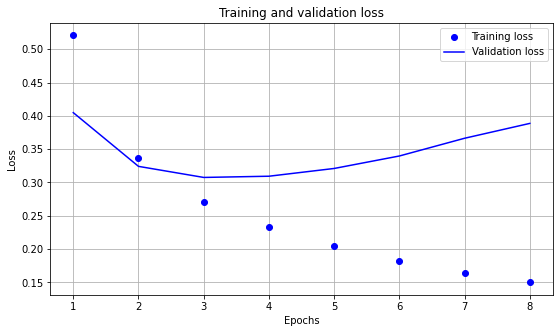

In [40]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

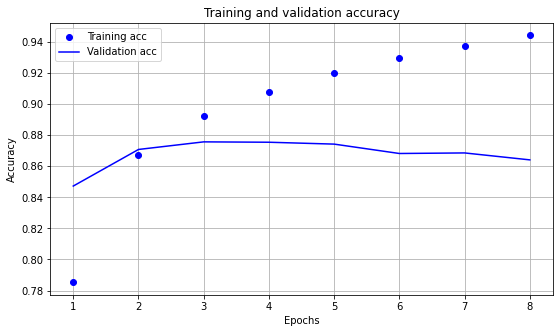

In [41]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [42]:
def print_my_examples(inputs, results, actual_values=None, limit=None):
    if actual_values is None:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}' for i in range(len(inputs))]
    else:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}\nactual value:{actual_values[i]}' for i in range(len(inputs))]
    if limit:
        result_for_printing = result_for_printing[:limit]
    print(*result_for_printing, sep='\n\n')

In [43]:
inputs = x_train[:10]
outputs = y_train[:10]
results = tf.sigmoid(model.predict(tf.constant(inputs)))
print_my_examples(inputs, results, outputs)

input:
"1-5p"
score: 0.941543
actual value:1

input:
"PLAYS: 8 (7 completed + 2 uncompleted) -17 races to pick up -more streamlined compared to TI3 -trading and political mechanics are improved -more flexibility to move your ships on the board  CONS: -balance issues: Jol-Nar (4wins) and FoS (3wins) seems OP compared to other races -action cards, agendas, objective cards feel to random -not enough variation in system tiles  CONCLUSION: overall improvement compared to TI3, but the balance issues left a sour taste"
score: 0.316993
actual value:0

input:
"Great first impression. I'm eager to try out this campaign/deck building and see where it goes."
score: 0.993274
actual value:1

input:
"BEAUTIFUL BIRDS! (and also a game)"
score: 0.976186
actual value:1

input:
"Spirit Island easily became my top 10 games, and it is also my favorite cooperative game!   It requires players to think wisely, think harder, and think ahead to win the game. Each player's Spirit has its own strengths and weakne

In [44]:
## APPLY MODEL ON NON-RATED COMMENTS

In [45]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(not_rated_comments.value.astype(str)))))
print_my_examples(list(not_rated_comments.value), results, limit=25)

input:
"Black foam board insert. Replacement red tile, but kept the misprinted tile too. Moedas & Co. coins."
score: 0.999826

input:
"Sleeved - SP 70x110 + SP 57x90 + SP 45x70 Painted mini's (to do)"
score: 0.999924

input:
"Picked up locally: Discovery Hut."
score: 0.447554

input:
"P1-4 B1-4 D3.56 T4 Opened, not sleeved RB read Ch1 Played Ch1 At Home"
score: 0.885652

input:
"2-6 Players // Best 6 // 240-480 min //  Prophecy of Kings PENDING"
score: 0.996984

input:
"Want 3rd edition plus expansions & goodies (incl. Kickstarter bonuses)"
score: 0.999623

input:
"Includes: The Herb Witches Expansion Includes: Upgraded Geek Bits from BGG Store"
score: 0.999736

input:
"No Rating. Haven't Played it.  I guess I was a different person over 4 years ago when I backed this. Since then my taste in games has  changed and I have several games that better fit the dungeon crawl niche for me. I'm sure it's an interesting game, just not for me. Oh well. SOLD!"
score: 0.082517

input:
"I played it 

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [46]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|        id |   rating_mean |   rating_count |
|-----------|---------------|----------------|
| 162886.00 |          8.35 |        3510.00 |
| 167355.00 |          8.41 |        1792.00 |
| 167791.00 |          8.21 |        8224.00 |
| 169427.00 |          8.59 |         220.00 |
| 169786.00 |          8.10 |        7336.00 |


In [47]:
not_rated_comments['rating'] = [round(float(r[0])*10, 1) for r in results]

In [48]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|        id |   rating_mean |   rating_count |
|-----------|---------------|----------------|
| 162886.00 |          8.68 |         309.00 |
| 167355.00 |          9.06 |         217.00 |
| 167791.00 |          8.88 |         438.00 |
| 169427.00 |          9.00 |          71.00 |
| 169786.00 |          8.78 |         590.00 |


In [49]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [50]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/A7IOpPt...","<a href=""https://boardgamegeek.com/boardgame/2...",7.387889,8.942222,7.503310,1,2017
1,"<img src=""https://cf.geekdo-images.com/oaD1ZQ3...","<a href=""https://boardgamegeek.com/boardgame/2...",8.198611,9.545161,8.603883,2,2021
2,"<img src=""https://cf.geekdo-images.com/OcnPGq9...","<a href=""https://boardgamegeek.com/boardgame/3...",7.865000,8.690909,8.043137,3,2021
3,"<img src=""https://cf.geekdo-images.com/cwUgf-f...","<a href=""https://boardgamegeek.com/boardgame/2...",6.358333,9.030841,7.585622,4,2021
4,"<img src=""https://cf.geekdo-images.com/6GqH14T...","<a href=""https://boardgamegeek.com/boardgame/3...",7.890014,8.945833,7.985636,5,2020


In [51]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [52]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Fantasy Realms,7.387889,8.942222,7.503310,1,2017
2,,Destinies,8.198611,9.545161,8.603883,2,2021
3,,The Adventures of Robin Hood,7.865000,8.690909,8.043137,3,2021
4,,Frosthaven,6.358333,9.030841,7.585622,4,2021
5,,Lost Ruins of Arnak,7.890014,8.945833,7.985636,5,2020


In [53]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Chronicles of Drunagor: Age of Darkness,9.509091,8.644444,9.387500,39,2021
2,,The Witcher: Old World,9.208333,8.900000,9.076190,28,2022
3,,Eclipse: Second Dawn for the Galaxy,8.746143,8.536585,8.713161,43,2020
4,,Brass: Birmingham,8.688374,8.938428,8.711170,27,2018
5,,Gloomhaven: Jaws of the Lion,8.599812,8.575188,8.597366,23,2020


In [54]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Chronicles of Drunagor: Age of Darkness,9.509091,8.644444,9.387500,39,2021
2,,Mosaic: A Story of Civilization,7.000000,9.585714,9.262500,12,2022
3,,The Witcher: Old World,9.208333,8.900000,9.076190,28,2022
4,,Kemet: Blood and Sand,8.454545,8.925926,8.747126,25,2021
5,,Merchants Cove,8.287500,9.385714,8.722642,20,2021


In [55]:
# model.save('saved_model\my_model')

In [56]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [57]:
# some examples on "long" comments vs short comments

In [58]:
# some long comments
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')
results = tf.sigmoid(model.predict(tf.constant(list(some_long_comments.value))))
print_my_examples(list(some_long_comments.value), results)

input:
"Played it with 2-player with and without an automata. Didn't enjoy it. The game looks stunning. The rules are ok, but the gameplay was not satisfying. I found it too hard to overlook the consequences of my actions."
score: 0.067088

input:
"Good mechanic but too heavy to learn, too heavy very too heavy to implement. It's too much chain attacks."
score: 0.089461

input:
"not played once. But game is known  one of best games i know of. Takes whole day to play a single match but it is worth it..."
score: 0.527495

input:
"Co-op 1-4, best 2 Action retrieval, area majority/influence, hand management, modular board, set collection, simultaneous action selection, solo/solitaire game, variable player powers"
score: 0.744331

input:
"EXPANSIONS: Prelude Venus Next Hellas & Elysium Colonies Turmoil  PROMOS: BGG User-Created Corporation Pack Turmoil Promo Cards Small Asteroid Card Penguins Card Self-Replicating Robots Card Snow Algae Card Atmo Collectors Card Jovian Lanterns Card Lunar Ex

## REGRESSOR

In [60]:
def build_regressor():
    return build_model(hub_layer, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=0.2)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x00000294450CE520>,
             param_grid={})

In [63]:
clf.best_score_

-2.427018880844116

In [64]:
clf.cv_results_

{'mean_fit_time': array([101.68815486]),
 'std_fit_time': array([4.36223421]),
 'mean_score_time': array([0.69396965]),
 'std_score_time': array([0.03970832]),
 'params': [{}],
 'split0_test_score': array([-2.8895402]),
 'split1_test_score': array([-2.08987617]),
 'split2_test_score': array([-2.30164027]),
 'mean_test_score': array([-2.42701888]),
 'std_test_score': array([0.33828537]),
 'rank_test_score': array([1])}

In [61]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"A very good game; have played 15-20 rounds so far. Many things to like about it, great design work, very accessible, fun classes and storyline and just so much content. Main criticism is that it can occasionally feel repetitive and unlocking new classes takes ages."
score: 8.01
actual: 8.00 

input: 
"The current apex of cooperative and solitaire games.  After hundreds of plays very few of the dozens of powers feel 'bad', all of the Spirits play incredibly differently. An incredible feat of thematic design, game-play balance, and challenge that rarely feels unfair."
score: 9.92
actual: 10.00 

input: 
"Ugh."
score: 4.82
actual: 1.00 

input: 
"First impression after a few plays (all 2P) is that this has the potential to sit on my top shelf for a long time. There's so much to like here, from the possibility of epic tile flip combos, to the way networking makes you bump up against other players, to the income and loan system.   Need to try it with more players, I think it would 

In [62]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]
results = clf.best_estimator_.predict(tf.constant(list(not_rated_comments.value.astype(str))), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\n")
print("-----------------------------------------------------------------------------------------------------")
results = tf.sigmoid(model.predict(inputs))
print_my_examples(inputs, results, limit=10)

input: 
"Owned expansions: The Herb Witches"
score: 8.15

input: 
"The smaller version of a gamer's game. But still a gamer's game. Be prepared to read a lot of rules. They needed more than one rule book to fit all the rules."
score: 8.97

input: 
"1-4 Players Worker placemement Engine/Tableau building"
score: 9.03

input: 
"Kickstarter Root: The Riverfolk Expansion (2018) Root: The Underworld Expansion (2020)  Asymmetrical play is a delight but a hindrance to quick explanation. Players need to be devoted.  Production is stellar and rule books are clear & concise."
score: 8.44

input: 
"Res Arcana is a tableau/engine/deck building card game with resource conversion by Thomas Lehmann (Race for the Galaxy). Rather generic magician duelling theme. Involves upfront planning because your deck is known at set-up which makes the game very strategic.  What makes it special? * You play with a deck of only 8 cards the whole game (random or drafted) * Unlike other deck builders, you can plan your